## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico45DegreeSun.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.633  0.367E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.275  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.517  0.363E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.686  0.286E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -1.982  0.185E+00    32214    41.12  0.161   [Radiance 0.660 micron]
     6  -2.058  0.117E+00    32916    45.39  0.177   [Radiance 0.660 micron]
     7  -2.115  0.869E-01    33822    50.39  0.197   [Radiance 0.660 micron]
     8  -2.248  0.716E-01    34773    55.23  0.216   [Radiance 0.660 micron]
     9  -2.317  0.582E-01    36387    63.02  0.246   [Radiance 0.660 micron]
    10  -2.383  0.495E-01    37970    70.28  0.275   [Radiance 0.660 micron]
    11  -2.459  0.433E-01    39678    77.49  0.303   [Radiance 0.660 micron]
    12  -2.519  0.380E-01    41683    85.26  0.333   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

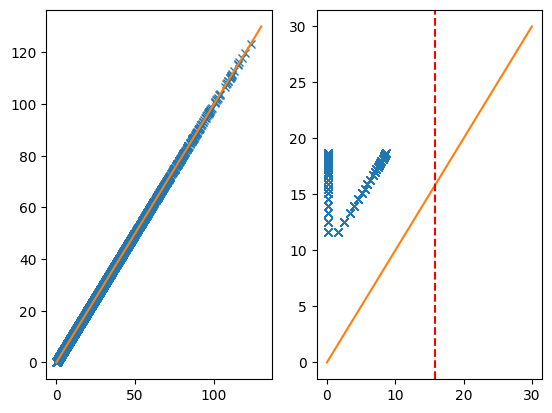

588.0475156412309
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.363E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.368E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.521  0.359E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.692  0.281E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -1.991  0.182E+00    32200    41.03  0.160   [Radiance 0.660 micron]
     6  -2.065  0.115E+00    32906    45.32  0.177   [Radiance 0.660 micron]
     7  -2.117  0.854E-01    33766    50.08  0.196   [Radiance 0.660 micron]
     8  -2.255  0.707E-01    34663    54.68  0.214   [Radiance 0.660 micron]
     9  -2.328  0.574E-01    36265    62.51  0.244   [Radiance 0.660 micron]
    10  -2.387  0.487E-01    37832    69.70  0.272   [Radiance 0.660 micron]
    11  -2.477  0.427E-01    39412    76.41  0.298   [Radiance 0.660 micron]
    12  -2.516  0.372E-01    41556    84.79  0.331   [Radianc

<Figure size 640x480 with 0 Axes>

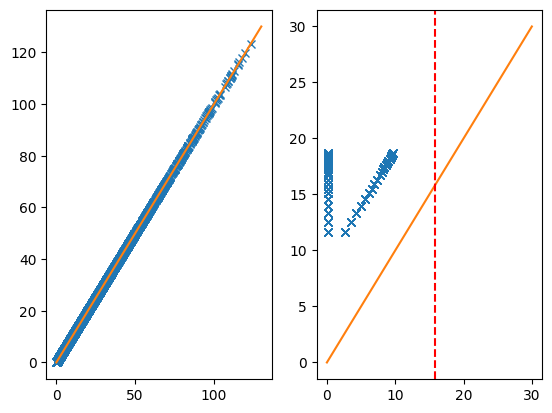

371.0275048007107
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.359E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.364E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.524  0.355E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.696  0.278E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -1.997  0.180E+00    32196    41.00  0.160   [Radiance 0.660 micron]
     6  -2.070  0.113E+00    32901    45.29  0.177   [Radiance 0.660 micron]
     7  -2.119  0.844E-01    33741    49.95  0.195   [Radiance 0.660 micron]
     8  -2.268  0.701E-01    34589    54.33  0.212   [Radiance 0.660 micron]
     9  -2.332  0.565E-01    36232    62.34  0.244   [Radiance 0.660 micron]
    10  -2.396  0.481E-01    37727    69.23  0.270   [Radiance 0.660 micron]
    11  -2.485  0.422E-01    39270    75.87  0.296   [Radiance 0.660 micron]
    12  -2.515  0.367E-01    41429    84.38  0.330   [Radianc

<Figure size 640x480 with 0 Axes>

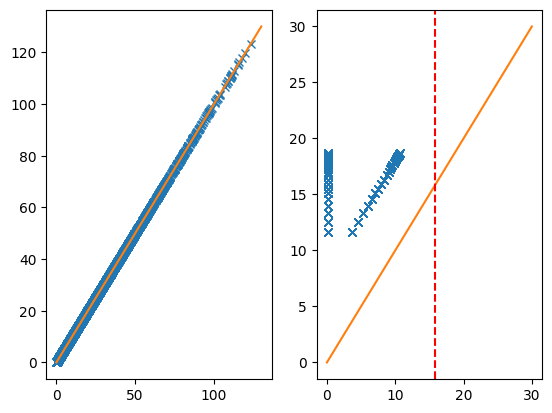

239.2761224481013
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.356E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.361E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.526  0.352E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.700  0.275E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.001  0.179E+00    32196    41.00  0.160   [Radiance 0.660 micron]
     6  -2.075  0.112E+00    32890    45.23  0.177   [Radiance 0.660 micron]
     7  -2.125  0.836E-01    33741    49.97  0.195   [Radiance 0.660 micron]
     8  -2.271  0.693E-01    34566    54.22  0.212   [Radiance 0.660 micron]
     9  -2.337  0.560E-01    36167    62.06  0.242   [Radiance 0.660 micron]
    10  -2.401  0.477E-01    37653    68.91  0.269   [Radiance 0.660 micron]
    11  -2.489  0.418E-01    39171    75.47  0.295   [Radiance 0.660 micron]
    12  -2.522  0.364E-01    41274    83.82  0.327   [Radianc

<Figure size 640x480 with 0 Axes>

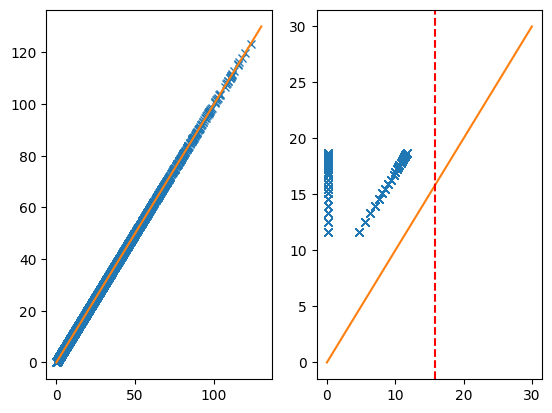

156.83617750799726
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.354E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.358E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.528  0.349E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.702  0.273E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.005  0.177E+00    32196    41.00  0.160   [Radiance 0.660 micron]
     6  -2.079  0.111E+00    32887    45.21  0.177   [Radiance 0.660 micron]
     7  -2.129  0.829E-01    33714    49.83  0.195   [Radiance 0.660 micron]
     8  -2.276  0.687E-01    34544    54.11  0.211   [Radiance 0.660 micron]
     9  -2.342  0.555E-01    36123    61.86  0.242   [Radiance 0.660 micron]
    10  -2.407  0.473E-01    37592    68.67  0.268   [Radiance 0.660 micron]
    11  -2.495  0.414E-01    39114    75.29  0.294   [Radiance 0.660 micron]
    12  -2.528  0.360E-01    41210    83.61  0.327   [Radian

<Figure size 640x480 with 0 Axes>

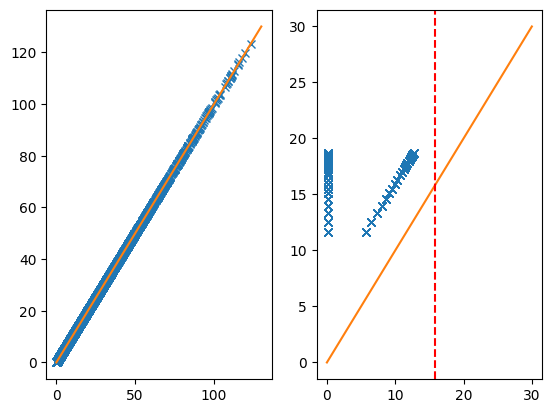

97.06114766869618
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.352E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.356E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.529  0.346E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.704  0.271E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.008  0.176E+00    32192    40.97  0.160   [Radiance 0.660 micron]
     6  -2.082  0.110E+00    32875    45.14  0.176   [Radiance 0.660 micron]
     7  -2.131  0.823E-01    33705    49.79  0.194   [Radiance 0.660 micron]
     8  -2.282  0.683E-01    34509    53.94  0.211   [Radiance 0.660 micron]
     9  -2.345  0.551E-01    36083    61.64  0.241   [Radiance 0.660 micron]
    10  -2.412  0.470E-01    37557    68.53  0.268   [Radiance 0.660 micron]
    11  -2.498  0.411E-01    39082    75.15  0.294   [Radiance 0.660 micron]
    12  -2.535  0.358E-01    41104    83.21  0.325   [Radianc

<Figure size 640x480 with 0 Axes>

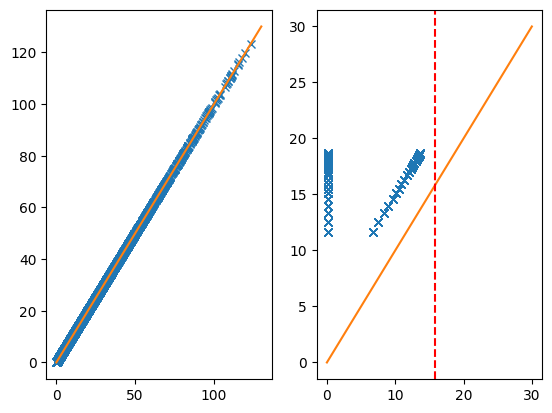

62.2742674223315
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.350E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.354E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.530  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.706  0.270E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.011  0.175E+00    32191    40.97  0.160   [Radiance 0.660 micron]
     6  -2.085  0.110E+00    32871    45.11  0.176   [Radiance 0.660 micron]
     7  -2.132  0.818E-01    33700    49.76  0.194   [Radiance 0.660 micron]
     8  -2.286  0.680E-01    34489    53.85  0.210   [Radiance 0.660 micron]
     9  -2.351  0.547E-01    36035    61.44  0.240   [Radiance 0.660 micron]
    10  -2.414  0.466E-01    37528    68.40  0.267   [Radiance 0.660 micron]
    11  -2.505  0.408E-01    39042    75.00  0.293   [Radiance 0.660 micron]
    12  -2.535  0.355E-01    41097    83.18  0.325   [Radiance

<Figure size 640x480 with 0 Axes>

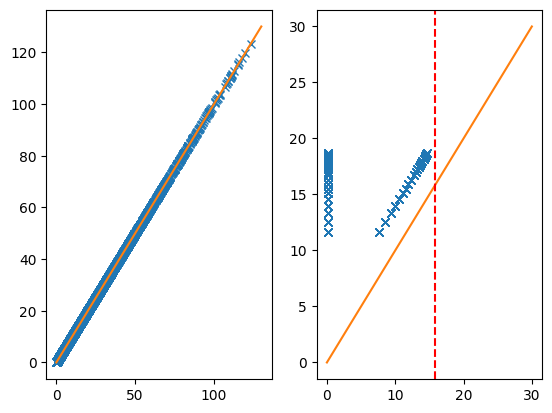

33.88780751737708
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.348E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.352E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.531  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.707  0.268E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.013  0.174E+00    32191    40.97  0.160   [Radiance 0.660 micron]
     6  -2.087  0.109E+00    32869    45.10  0.176   [Radiance 0.660 micron]
     7  -2.134  0.814E-01    33692    49.72  0.194   [Radiance 0.660 micron]
     8  -2.287  0.677E-01    34487    53.84  0.210   [Radiance 0.660 micron]
     9  -2.357  0.545E-01    35998    61.26  0.239   [Radiance 0.660 micron]
    10  -2.417  0.462E-01    37514    68.34  0.267   [Radiance 0.660 micron]
    11  -2.508  0.406E-01    39035    74.97  0.293   [Radiance 0.660 micron]
    12  -2.540  0.353E-01    41046    82.99  0.324   [Radianc

<Figure size 640x480 with 0 Axes>

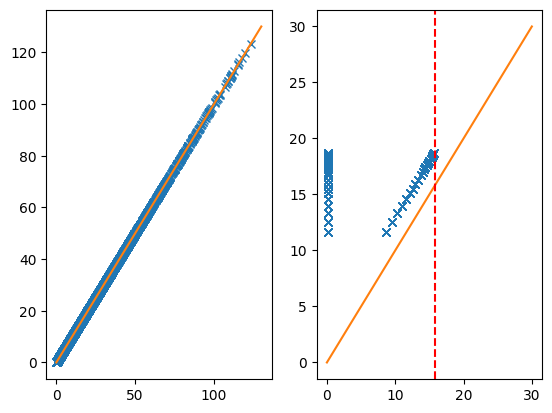

17.761933686548822
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.347E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.351E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.532  0.341E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.708  0.267E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.015  0.173E+00    32191    40.97  0.160   [Radiance 0.660 micron]
     6  -2.089  0.109E+00    32862    45.06  0.176   [Radiance 0.660 micron]
     7  -2.137  0.810E-01    33691    49.71  0.194   [Radiance 0.660 micron]
     8  -2.290  0.673E-01    34478    53.80  0.210   [Radiance 0.660 micron]
     9  -2.360  0.542E-01    35978    61.17  0.239   [Radiance 0.660 micron]
    10  -2.420  0.460E-01    37498    68.26  0.267   [Radiance 0.660 micron]
    11  -2.512  0.404E-01    39022    74.94  0.293   [Radiance 0.660 micron]
    12  -2.544  0.351E-01    41025    82.92  0.324   [Radian

<Figure size 640x480 with 0 Axes>

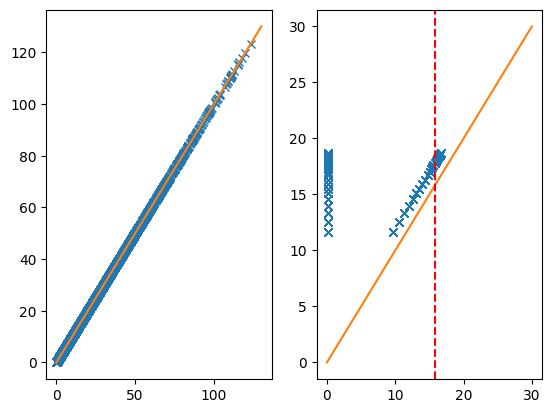

8.068167695930445
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.345E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.349E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.533  0.340E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.709  0.266E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.017  0.173E+00    32191    40.97  0.160   [Radiance 0.660 micron]
     6  -2.091  0.108E+00    32850    44.99  0.176   [Radiance 0.660 micron]
     7  -2.140  0.807E-01    33680    49.65  0.194   [Radiance 0.660 micron]
     8  -2.291  0.670E-01    34475    53.79  0.210   [Radiance 0.660 micron]
     9  -2.363  0.540E-01    35938    60.99  0.238   [Radiance 0.660 micron]
    10  -2.421  0.458E-01    37492    68.23  0.267   [Radiance 0.660 micron]
    11  -2.515  0.402E-01    38972    74.74  0.292   [Radiance 0.660 micron]
    12  -2.544  0.350E-01    40998    82.81  0.323   [Radianc

<Figure size 640x480 with 0 Axes>

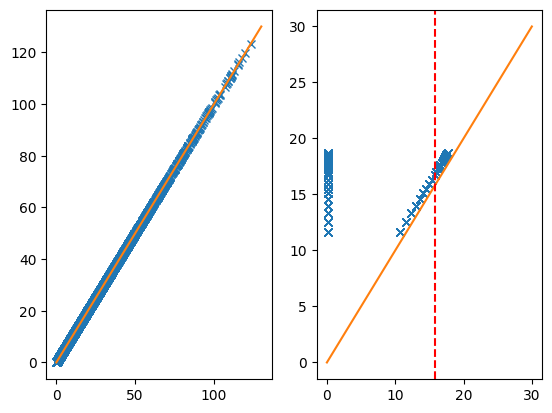

2.3808083756399103
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.348E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.533  0.338E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.710  0.265E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.018  0.172E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.093  0.108E+00    32849    44.99  0.176   [Radiance 0.660 micron]
     7  -2.141  0.804E-01    33679    49.64  0.194   [Radiance 0.660 micron]
     8  -2.294  0.668E-01    34463    53.74  0.210   [Radiance 0.660 micron]
     9  -2.363  0.538E-01    35930    60.95  0.238   [Radiance 0.660 micron]
    10  -2.425  0.456E-01    37474    68.17  0.266   [Radiance 0.660 micron]
    11  -2.514  0.401E-01    38978    74.77  0.292   [Radiance 0.660 micron]
    12  -2.554  0.349E-01    40922    82.53  0.322   [Radian

<Figure size 640x480 with 0 Axes>

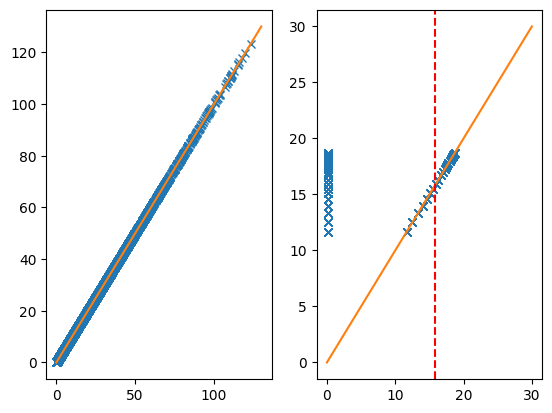

0.16370652004228767
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.347E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.534  0.337E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.711  0.264E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.019  0.172E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.094  0.107E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.142  0.802E-01    33670    49.60  0.194   [Radiance 0.660 micron]
     8  -2.295  0.666E-01    34464    53.75  0.210   [Radiance 0.660 micron]
     9  -2.365  0.537E-01    35914    60.88  0.238   [Radiance 0.660 micron]
    10  -2.427  0.455E-01    37450    68.06  0.266   [Radiance 0.660 micron]
    11  -2.515  0.399E-01    38970    74.75  0.292   [Radiance 0.660 micron]
    12  -2.558  0.348E-01    40856    82.29  0.321   [Radia

<Figure size 640x480 with 0 Axes>

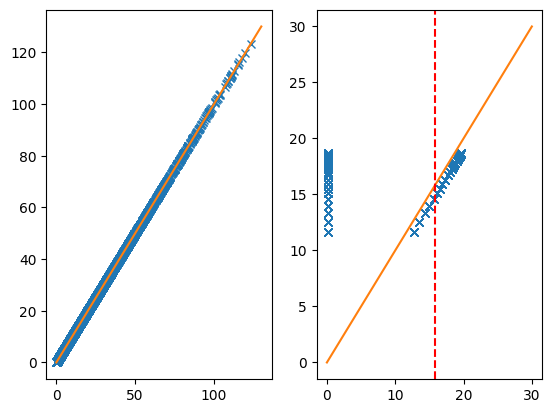

0.46107630273030803
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.346E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.534  0.336E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.711  0.263E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.020  0.171E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.095  0.107E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.144  0.799E-01    33669    49.61  0.194   [Radiance 0.660 micron]
     8  -2.299  0.664E-01    34452    53.69  0.210   [Radiance 0.660 micron]
     9  -2.366  0.534E-01    35919    60.90  0.238   [Radiance 0.660 micron]
    10  -2.430  0.454E-01    37416    67.92  0.265   [Radiance 0.660 micron]
    11  -2.514  0.398E-01    38969    74.75  0.292   [Radiance 0.660 micron]
    12  -2.564  0.348E-01    40792    82.06  0.321   [Radia

<Figure size 640x480 with 0 Axes>

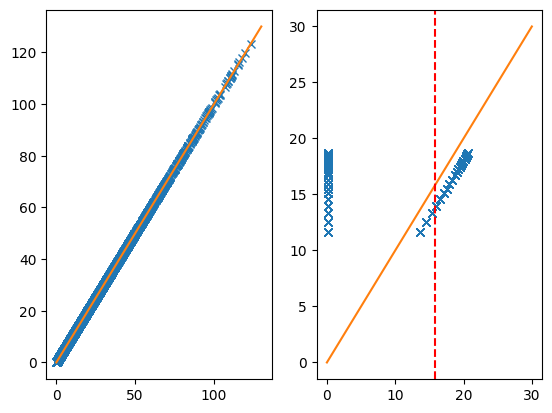

2.5053020064160596
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.341E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.345E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.534  0.335E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.712  0.265E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.023  0.171E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.096  0.107E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.144  0.797E-01    33671    49.62  0.194   [Radiance 0.660 micron]
     8  -2.302  0.663E-01    34444    53.65  0.210   [Radiance 0.660 micron]
     9  -2.368  0.532E-01    35921    60.92  0.238   [Radiance 0.660 micron]
    10  -2.430  0.452E-01    37422    67.95  0.265   [Radiance 0.660 micron]
    11  -2.519  0.397E-01    38952    74.70  0.292   [Radiance 0.660 micron]
    12  -2.561  0.346E-01    40817    82.16  0.321   [Radian

<Figure size 640x480 with 0 Axes>

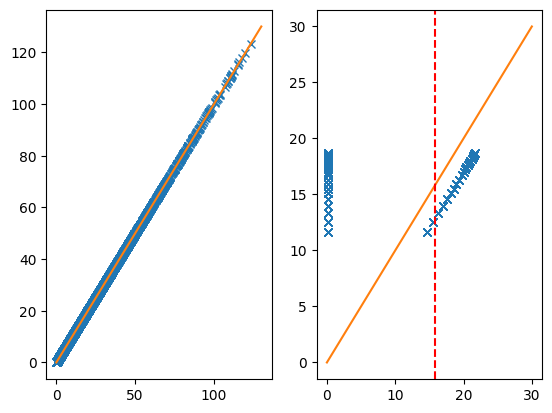

6.054382454923166
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.340E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.334E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.713  0.264E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.023  0.170E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.096  0.107E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.146  0.796E-01    33667    49.59  0.194   [Radiance 0.660 micron]
     8  -2.303  0.661E-01    34442    53.64  0.210   [Radiance 0.660 micron]
     9  -2.369  0.531E-01    35919    60.91  0.238   [Radiance 0.660 micron]
    10  -2.432  0.451E-01    37414    67.91  0.265   [Radiance 0.660 micron]
    11  -2.522  0.396E-01    38930    74.61  0.291   [Radiance 0.660 micron]
    12  -2.560  0.345E-01    40821    82.18  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

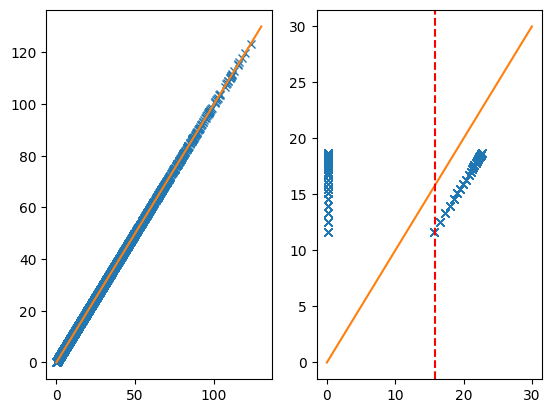

10.398128469814392
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.340E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.333E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.713  0.263E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -1.992  0.170E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.101  0.109E+00    32788    44.63  0.174   [Radiance 0.660 micron]
     7  -2.175  0.802E-01    33621    49.32  0.193   [Radiance 0.660 micron]
     8  -2.286  0.648E-01    34512    53.97  0.211   [Radiance 0.660 micron]
     9  -2.363  0.533E-01    35862    60.61  0.237   [Radiance 0.660 micron]
    10  -2.432  0.454E-01    37329    67.51  0.264   [Radiance 0.660 micron]
    11  -2.522  0.397E-01    38836    74.17  0.290   [Radiance 0.660 micron]
    12  -2.557  0.345E-01    40731    81.83  0.320   [Radian

<Figure size 640x480 with 0 Axes>

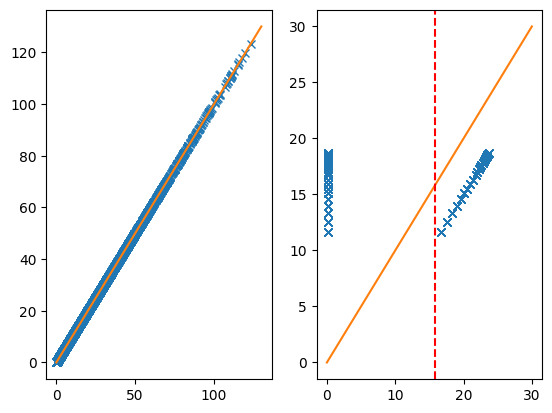

15.508418055586842
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.339E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.333E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.262E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.022  0.170E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.097  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.151  0.793E-01    33652    49.50  0.193   [Radiance 0.660 micron]
     8  -2.305  0.656E-01    34443    53.65  0.210   [Radiance 0.660 micron]
     9  -2.371  0.529E-01    35905    60.84  0.238   [Radiance 0.660 micron]
    10  -2.433  0.450E-01    37389    67.80  0.265   [Radiance 0.660 micron]
    11  -2.525  0.394E-01    38900    74.47  0.291   [Radiance 0.660 micron]
    12  -2.563  0.343E-01    40783    82.02  0.320   [Radian

<Figure size 640x480 with 0 Axes>

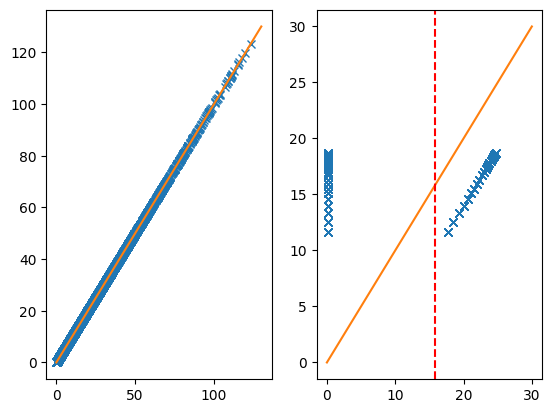

20.42768040856036
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.338E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.332E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.262E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.026  0.169E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.098  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.148  0.791E-01    33652    49.50  0.193   [Radiance 0.660 micron]
     8  -2.308  0.657E-01    34425    53.54  0.209   [Radiance 0.660 micron]
     9  -2.373  0.527E-01    35906    60.84  0.238   [Radiance 0.660 micron]
    10  -2.436  0.448E-01    37393    67.82  0.265   [Radiance 0.660 micron]
    11  -2.528  0.393E-01    38906    74.50  0.291   [Radiance 0.660 micron]
    12  -2.564  0.342E-01    40810    82.13  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

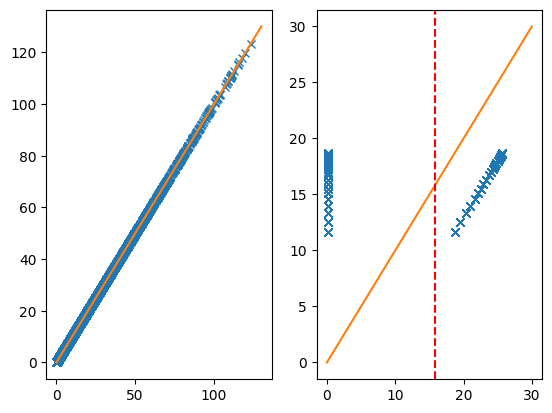

27.038052366743997
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.338E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.341E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.331E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.261E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.027  0.169E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.099  0.106E+00    32843    44.95  0.176   [Radiance 0.660 micron]
     7  -2.150  0.790E-01    33651    49.50  0.193   [Radiance 0.660 micron]
     8  -2.309  0.656E-01    34418    53.51  0.209   [Radiance 0.660 micron]
     9  -2.374  0.526E-01    35905    60.84  0.238   [Radiance 0.660 micron]
    10  -2.435  0.447E-01    37385    67.78  0.265   [Radiance 0.660 micron]
    11  -2.531  0.393E-01    38890    74.42  0.291   [Radiance 0.660 micron]
    12  -2.564  0.341E-01    40819    82.17  0.321   [Radian

<Figure size 640x480 with 0 Axes>

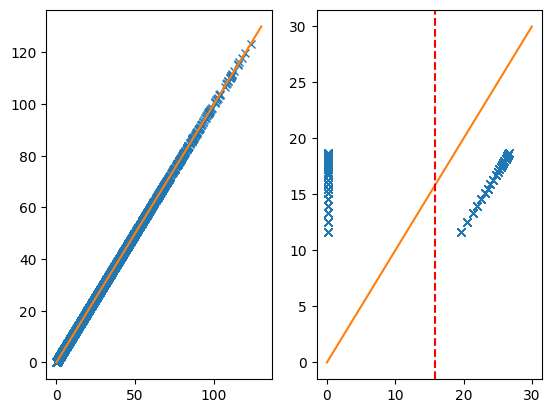

33.23618121428229
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.337E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.341E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.331E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.715  0.261E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.027  0.169E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.099  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.151  0.789E-01    33648    49.48  0.193   [Radiance 0.660 micron]
     8  -2.310  0.655E-01    34418    53.51  0.209   [Radiance 0.660 micron]
     9  -2.375  0.525E-01    35905    60.84  0.238   [Radiance 0.660 micron]
    10  -2.436  0.447E-01    37384    67.77  0.265   [Radiance 0.660 micron]
    11  -2.533  0.392E-01    38887    74.42  0.291   [Radiance 0.660 micron]
    12  -2.564  0.340E-01    40820    82.18  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

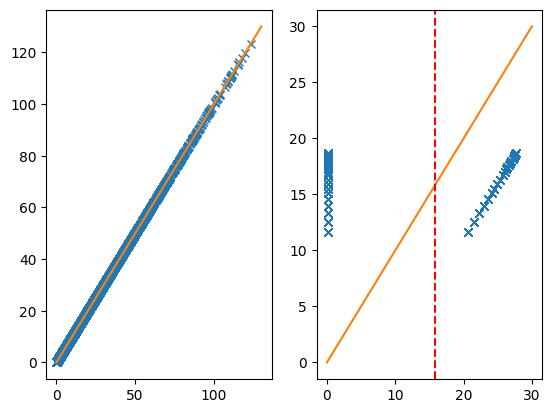

39.40192717567897


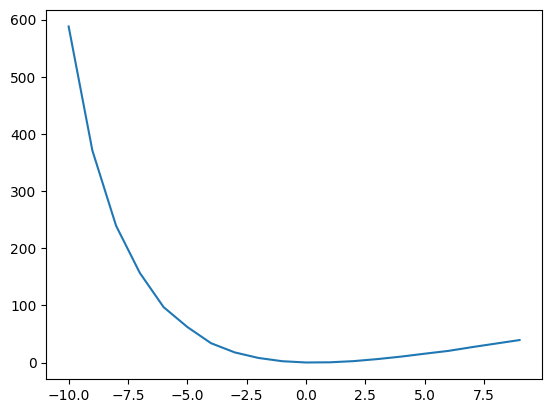

In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(-10, 10):
    losses.append(get_loss(i))
    plot(None)
    print(losses[i+10])
py.plot(range(-10, 10),losses)


Text(0.5, 1.0, 'Loss vs Reff Using Ground Truth Geometric Extinction')

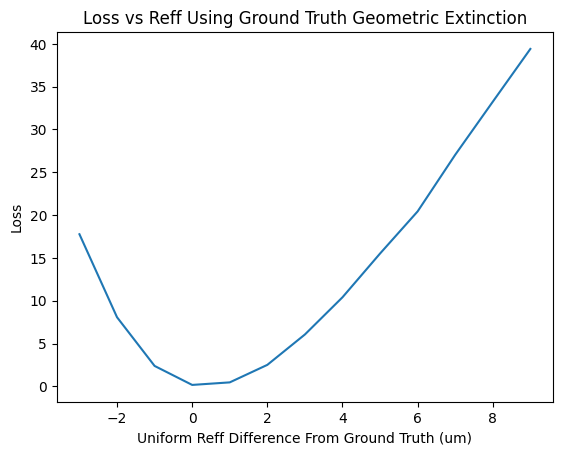

In [7]:
py.plot(range(-3, 10), np.array(losses)[7:])
py.xlabel("Uniform Reff Difference From Ground Truth (um)")
py.ylabel("Loss")
py.title("Loss vs Reff Using Ground Truth Geometric Extinction")